## 3D modelling with TADdyn

__running time__: < 30 min

In this notebook we will show an application of the <a name="ref-1"/>[TADdyn](#cite-taddyn) tool to generate four-dimensional (4D) models of a region of 1.5 Mb centered around the Sox2 promoter represented at 5kb resolution.
3D structures of the locus are obtained in the B-cell stage and a restraint-based dynamics will be simulated during the reprogramming process.

![](images/taddyn.png)

First we load the libraries:

In [2]:
from pickle import dump, load
import os, shutil
import matplotlib.pyplot as plt
from pytadbit.parsers.hic_parser import read_matrix
from pytadbit.utils.file_handling import mkdir
from pytadbit.modelling.structuralmodels import StructuralModels, load_structuralmodels
from pytadbit.modelling.structuralmodel import StructuralModel
from pytadbit.utils.extraviews      import plot_3d_model
from taddyn.Chromosome_region import Chromosome_region

Then the Hi-C interaction matrices of the three stages we aim to simulate are loaded. In this case, we will limit the analysis to the B-cell, day 4 (D4), and day 6 (D6) stages of the reprogramming process. These matrices will be used to extract spatial restraints at these three time-points of the dynamics using the same strategy applied in TADbit.

In [3]:
# 1 - Load the Hi-C maps at each time-point
PATH = "../sox2_matrices/"

nrm_files = [PATH+"nrm_Sox2_B.txt",
             PATH+"nrm_Sox2_D4.txt",
             PATH+"nrm_Sox2_D6.txt"]

mkdir("../results/TADdyn")
nrm_data =  read_matrix(nrm_files, one=False)

/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/parsers/hic_parser.py:346: UserWarning: WARNING: non integer values
  warn('WARNING: non integer values')


We filter out low-count columns

In [3]:
# filter low count columns
for timepoint in range(len(nrm_files)):
    nrm_data[timepoint].filter_columns()


     7    10    94   190   191   246   278   297
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn

Found 11 of 300 columns with poor signal
Found 9 of 300 columns with poor signal
Found 9 of 300 columns with poor signal


/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_filtering.py:78: RankWarning: Polyfit may be poorly conditioned
  z = np.polyfit(y, x, order)
/scratch/3DAROC21/miniconda2/envs/taddyn/lib/python2.7/site-packages/pytadbit/utils/hic_fi

Now we perform the dynamics simulation. Per each of the 50 replicas, TADdyn is using in the background the LAMMPS software (https://www.lammps.org/) for polymer-based simulations to compute a trajectory which will go through all the experimental time-points. In this case time, at t=0 the structure will model the B-cell stage, next after timesteps_per_k=10,000 timestep it will reach the D4-stage, and finally after additional timesteps_per_k=10,000 timesteps the D6-stage. The dynamics is simulated by imposing both physics-based restraints, which include the chain connectivity and the excluded-volume interactions, and Hi-C-based restraints. The latter are dynamically changed along the simulation in a way that at the time-points of the experiments (B, D4, and D6) the value of the spring constant (k) and the equilibrium distance (deq) of each restraints are the ones extrapolated from the corresponding Hi-C interaction matrix. The conversion of the Hi-C contact propensity to spatial restraints is the same as in TADbit. In this case, at time t=0 we will apply the restraints obtained from the Hi-C interaction matrix in B-cells, at t=10,000 the ones from the D4-stage and at t=20,000 the ones from the D6-stage. Between time-points the parameters k and deq are changed linearly.

In [4]:
chr_region = Chromosome_region("Chr3", hic=nrm_data,
                               resolution=5000, size=len(nrm_data[0]),
                               zeros=[nrm_data_timepoint.bads for nrm_data_timepoint in nrm_data])
nparticles=300
os.system('rm -rf ../results/TADdyn/TADdyn_on_Sox2_test_%sparticles'%nparticles)           
ensemble_of_models = chr_region.model_region(1, nparticles, n_models=50, n_keep=50,
                          n_cpus=8, cleanup=False, hide_log=False,
                          initial_conformation='random',                          
                          timesteps_per_k=10000, stages=[0,1,2],
                          config={'scale'  : 0.01 , 'kbending': 0.0,
                                  'maxdist': 300  , 'upfreq'  : 1.0, 
                                  'lowfreq': -1.0},
                          tmp_folder='../results/TADdyn/TADdyn_on_Sox2_test_%sparticles/' % nparticles,
                          timeout_job=90000, useColvars=False)


Performing minimization run...
Performing minimization run...
Performing minimization run...
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
('#Time_points', [0, 1, 2])
# Step 0 - 1
('#Time_points', [0, 1, 2])
# Step 0 - 1
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
# Step 1 - 2
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
('#Time_points', [0, 1, 2])
# Step 0 - 1
('#Time_points', [0, 1, 2])
# Step 0 - 1
Performing minimization run...
(

In [ ]:
nparticles=300
with open("../results/TADdyn/TADdyn_on_Sox2_test_%sparticles.pickle" % nparticles, 'wb') as pickle_file:
    dump(ensemble_of_models,pickle_file)

After obtaining the models, we can do time-dependent analysis. First we will load the TADDyn models in TADbit so we can benefit from the plots and analysis that it provides:

In [4]:
from pickle import load
nparticles=300
ensemble_of_models=load(open("../results/TADdyn/TADdyn_on_Sox2_test_%sparticles.pickle" % nparticles))

In [5]:
n_models=50
sm_snapshots=[]
for stage in [1, 2]:
    models_stage = dict((i, StructuralModel(ensemble_of_models['models'][mod]))
                    for i, mod in enumerate(ensemble_of_models['stages'][stage*ensemble_of_models['models_per_step']]))
    sm_stage =StructuralModels(
            ensemble_of_models['loci'], models_stage, {}, 
            resolution=ensemble_of_models['resolution'], original_data=ensemble_of_models['original_data'][stage],
            zscores=ensemble_of_models['zscores'][stage], config=ensemble_of_models['config'],
            zeros=ensemble_of_models['zeros'],restraints=ensemble_of_models['restraints'])
    sm_snapshots.append(sm_stage)

In [6]:
sm=[]
for stage in ensemble_of_models['stages']:
    if stage == 0:
        continue
    models_stage = dict((i, StructuralModel(ensemble_of_models['models'][mod]))
                    for i,mod in enumerate(ensemble_of_models['stages'][stage]))
    snapshot = stage//ensemble_of_models['models_per_step']
    sm_stage =StructuralModels(
            ensemble_of_models['loci'], models_stage, {}, 
            resolution=ensemble_of_models['resolution'], original_data=ensemble_of_models['original_data'][snapshot],
            zscores=ensemble_of_models['zscores'][snapshot], config=ensemble_of_models['config'],
            zeros=ensemble_of_models['zeros'],restraints=ensemble_of_models['restraints'])
    sm.append(sm_stage)

For instance, We can plot the Z-score distributions of the Hi-C counts at the different time-points.

1 - Z-score plots


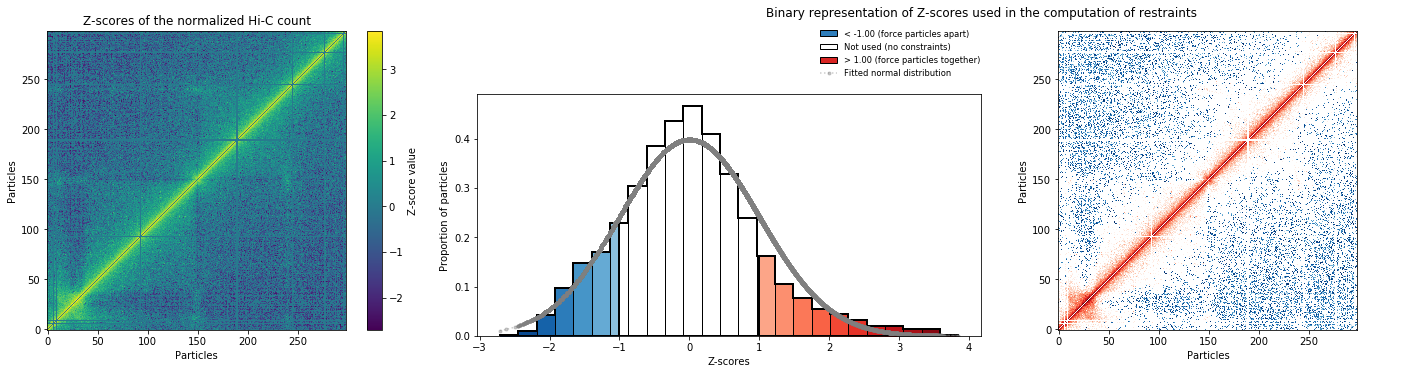

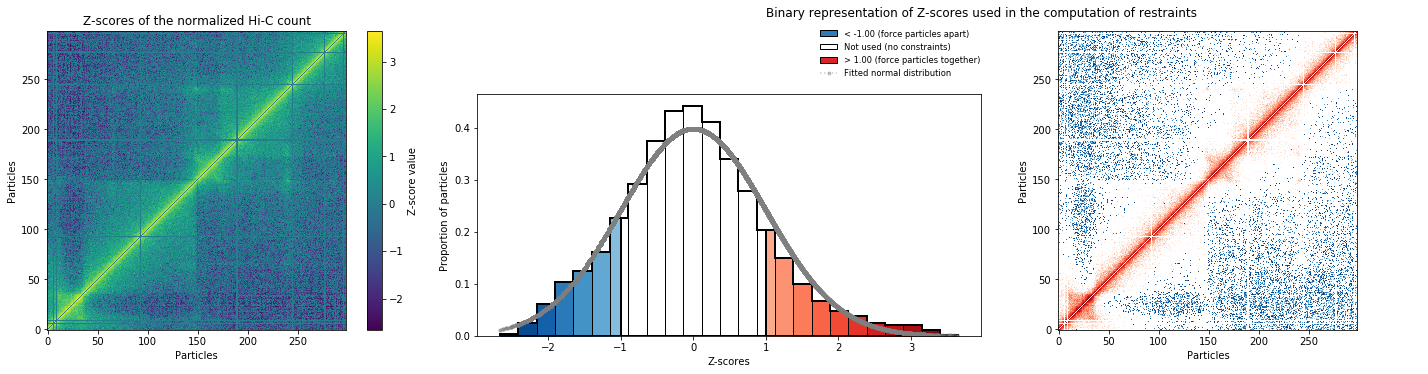

In [7]:
print( "1 - Z-score plots" )
# A. TADbit z-score plot per stage (Figure 1B)
for stage in [0, 1]:
    sm_snapshots[stage].zscore_plot()

We can plot the contact map obtained from the models and study its evolution along the trajectory.

3 - Contact matrices


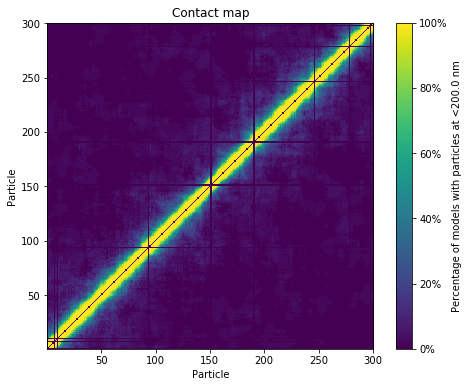

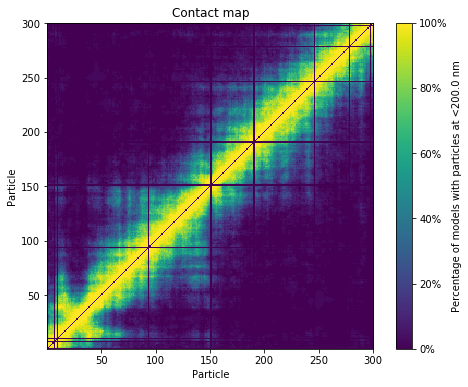

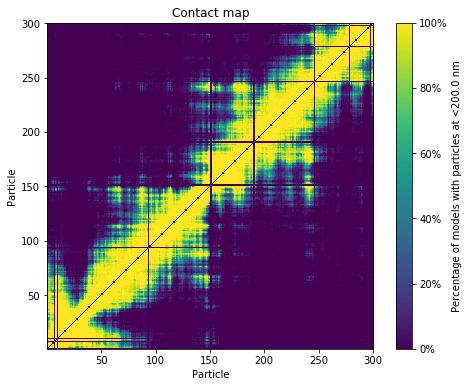

In [8]:
print( "3 - Contact matrices" )
timestep=0
fig = plt.figure(figsize=(8, 6))
axe = fig.add_subplot(111)
sm[timestep].contact_map(cutoff=200., axe=axe)
plt.show()
timestep=25
fig = plt.figure(figsize=(8, 6))
axe = fig.add_subplot(111)
sm[timestep].contact_map(cutoff=200., axe=axe)
plt.show()
timestep=199
fig = plt.figure(figsize=(8, 6))
axe = fig.add_subplot(111)
sm[timestep].contact_map(cutoff=200., axe=axe)
plt.show()

Similarly, we can visualize the 3D models at different timesteps and collect them to generate a video of the locus dynamics. In this case, models reveal that at day 6 (D6) a new domains has been formed "caging" the promoter of the Sox2 locus.

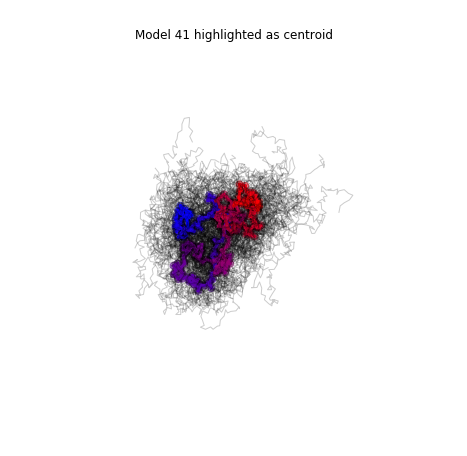

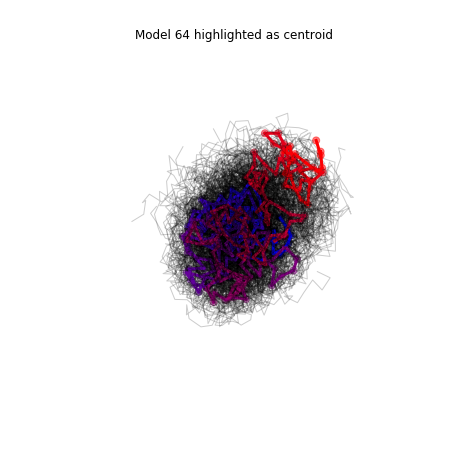

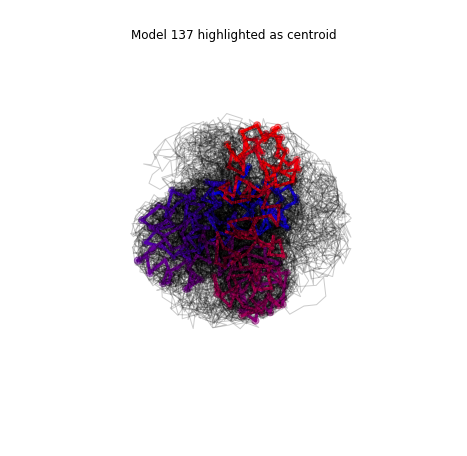

In [9]:
timestep=0
sm[timestep].view_models(tool='plot')
timestep=25
sm[timestep].view_models(tool='plot')
timestep=199
sm[timestep].view_models(tool='plot')

### Questions

- True or False? In case it is false try to correct the sentence:
 1. Both TADdyn and TADbit use Montecarlo simulations for models' generation.
 2. The definition of the restraints from an Hi-C map is the same in TADbit and TADdyn.

### References

<a name="cite-taddyn"/><sup>[](#ref-1) </sup>Di Stefano, M., Stadhouders, R., Farabella, I. et al. _Transcriptional activation during cell reprogramming correlates with the formation of 3D open chromatin hubs._ Nat Commun 11, 2564 (2020). https://doi.org/10.1038/s41467-020-16396-1.